In [ ]:
# heavy_tails.py
# ------------------------------------------------------------
# Generators for heavy-tailed data:
#   - Symmetric Pareto (alpha=2)
#   - Asymmetric two-sided Pareto (alpha=2, p != 0.5)
#   - Heavy-tailed mixtures (Pareto/Normal/Student-t/Cauchy)
#   - High-dimensional Pareto (multivariate regularly varying)
#
# Notes:
# Pareto Type I with scale xm (support [xm, inf)), CDF: F(x)=1-(xm/x)^alpha.
# Inverse-CDF sampling: X = xm * U^(-1/alpha), U ~ Uniform(0,1).
# For alpha <= 1, mean is infinite; for alpha <= 2, variance is infinite.
# With alpha = 2, mean is finite, variance diverges.
# ------------------------------------------------------------

from __future__ import annotations
import numpy as np
from typing import Dict, List, Tuple, Optional

Array = np.ndarray
_rng = np.random.default_rng()

def set_seed(seed: Optional[int] = None) -> None:
    """Set the random seed for reproducibility."""
    global _rng
    _rng = np.random.default_rng(seed)

# -------------------------- Pareto cores --------------------------

def pareto_rvs(alpha: float, size: int | Tuple[int, ...], xm: float = 1.0) -> Array:
    """
    Pareto Type I samples with shape alpha > 0 and scale xm > 0.
    Support: [xm, ∞). Uses inverse CDF: X = xm * U^(-1/alpha), U ~ U(0,1).
    """
    if alpha <= 0 or xm <= 0:
        raise ValueError("alpha and xm must be positive.")
    U = _rng.random(size=size)
    return xm * U ** (-1.0 / alpha)

def symmetric_pareto(alpha: float = 2.0, n: int = 10_000, xm: float = 1.0) -> Array:
    """
    Two-sided (symmetric) Pareto: draw magnitude from Pareto(alpha, xm),
    sign from Bernoulli(0.5). Returns shape (n,).
    """
    mags = pareto_rvs(alpha=alpha, size=n, xm=xm)
    signs = _rng.choice([-1.0, 1.0], size=n)  # p=0.5 each
    return signs * mags

def asymmetric_pareto(alpha: float = 2.0, n: int = 10_000, p_pos: float = 0.7,
                      xm_pos: float = 1.0, xm_neg: float = 1.0) -> Array:
    """
    Two-sided Pareto with asymmetric tail probability:
      P(X>0) = p_pos, P(X<0)=1-p_pos.
    Magnitudes on + and - sides can have different scales (xm_pos, xm_neg).
    Returns shape (n,).
    """
    if not (0.0 < p_pos < 1.0):
        raise ValueError("p_pos must be in (0,1).")
    n_pos = _rng.binomial(n, p_pos)
    n_neg = n - n_pos
    pos = pareto_rvs(alpha=alpha, size=n_pos, xm=xm_pos)
    neg = -pareto_rvs(alpha=alpha, size=n_neg, xm=xm_neg)
    x = np.empty(n, dtype=float)
    x[:n_pos] = pos
    x[n_pos:] = neg
    _rng.shuffle(x)
    return x

# ----------------------- Heavy-tailed mixtures -----------------------

def mixture_rvs(components: List[Dict], n: int) -> Array:
    """
    Flexible 1D mixture sampler.
    Each component is a dict with:
      - 'w' : weight (positive; will be normalized)
      - 'type' : one of {'pareto','normal','t','cauchy'}
      - For 'pareto': params 'alpha' (>0), 'xm' (>0)
      - For 'normal': params 'mu', 'sigma' (>0)
      - For 't': params 'df' (>0), optional 'scale' (>0, default=1.0)
      - For 'cauchy': optional 'x0' (location, default=0.0), 'gamma' (>0, default=1.0)
    Example:
      components = [
        {'w':0.8, 'type':'normal', 'mu':0, 'sigma':1},
        {'w':0.2, 'type':'pareto', 'alpha':2, 'xm':1},
      ]
    Returns shape (n,).
    """
    if len(components) == 0:
        raise ValueError("Provide at least one component.")

    weights = np.array([c['w'] for c in components], dtype=float)
    if np.any(weights <= 0):
        raise ValueError("All component weights must be positive.")
    weights = weights / weights.sum()

    # Assign each sample to a component
    comp_idx = _rng.choice(len(components), size=n, p=weights)
    out = np.empty(n, dtype=float)

    for k, comp in enumerate(components):
        idx = np.where(comp_idx == k)[0]
        if idx.size == 0:
            continue
        t = comp['type'].lower()

        if t == 'pareto':
            alpha = float(comp['alpha'])
            xm = float(comp.get('xm', 1.0))
            out[idx] = pareto_rvs(alpha=alpha, xm=xm, size=idx.size)

        elif t == 'normal':
            mu = float(comp.get('mu', 0.0))
            sigma = float(comp.get('sigma', 1.0))
            if sigma <= 0:
                raise ValueError("Normal sigma must be > 0.")
            out[idx] = _rng.normal(loc=mu, scale=sigma, size=idx.size)

        elif t == 't':
            df = float(comp.get('df', 3.0))
            scale = float(comp.get('scale', 1.0))
            mu = float(comp.get('mu', 0.0))  # location (shift)
            if df <= 0 or scale <= 0:
                raise ValueError("Student-t df and scale must be > 0.")
            # Student-t via normal / sqrt(chi2/df)
            z = _rng.normal(size=idx.size)
            chi2 = _rng.chisquare(df=df, size=idx.size)
            out[idx] = mu + (z / np.sqrt(chi2 / df)) * scale


        elif t == 'cauchy':
            x0 = float(comp.get('x0', 0.0))
            gamma = float(comp.get('gamma', 1.0))
            if gamma <= 0:
                raise ValueError("Cauchy gamma must be > 0.")
            # inverse CDF: X = x0 + gamma * tan(pi*(U-0.5))
            U = _rng.random(idx.size)
            out[idx] = x0 + gamma * np.tan(np.pi * (U - 0.5))

        else:
            raise ValueError(f"Unknown component type: {t}")

    return out

# ---------------- High-dimensional Pareto (multivariate) ----------------

def unit_sphere_directions(n: int, d: int) -> Array:
    """
    Sample n directions uniformly on the unit sphere S^{d-1}
    by normalizing standard normals.
    Returns shape (n, d).
    """
    Z = _rng.normal(size=(n, d))
    norms = np.linalg.norm(Z, axis=1, keepdims=True)
    # Avoid rare zero norm (practically impossible in float)
    norms = np.where(norms == 0.0, 1.0, norms)
    return Z / norms

def high_dimensional_pareto(alpha: float = 2.0, n: int = 10_000, d: int = 50, xm: float = 1.0) -> Array:
    """
    Multivariate regularly varying sample in R^d:
      X = R * U, where U is uniform on the unit sphere S^{d-1}
      and R ~ Pareto(alpha, xm).
    Returns shape (n, d).
    """
    if d < 1:
        raise ValueError("Dimension d must be >= 1.")
    R = pareto_rvs(alpha=alpha, size=n, xm=xm)  # radial
    U = unit_sphere_directions(n, d)            # direction
    return (R[:, None] * U)

# --------------------------- Convenience demos ---------------------------

def demo(n: int = 10_000) -> None:
    set_seed(42)

    # 1) Symmetric Pareto (alpha=2)
    x_sym = symmetric_pareto(alpha=2.0, n=n, xm=1.0)

    # 2) Asymmetric Pareto (alpha=2, P(+) = 0.7)
    x_asym = asymmetric_pareto(alpha=2.0, n=n, p_pos=0.7, xm_pos=1.0, xm_neg=1.0)

    # 3) Heavy-tailed mixture (80% N(0,1), 20% Pareto(alpha=2))
    mix_cfg = [
        {'w': 0.80, 'type': 'normal', 'mu': 0.0, 'sigma': 1.0},
        {'w': 0.20, 'type': 'pareto', 'alpha': 2.0, 'xm': 1.0},
    ]
    x_mix = mixture_rvs(components=mix_cfg, n=n)

    # 4) High-dimensional Pareto (d=50)
    X_hd = high_dimensional_pareto(alpha=2.0, n=n, d=50, xm=1.0)

    # Quick sanity prints
    def summarize(arr: Array, name: str):
        m = np.mean(arr)
        q = np.quantile(arr, [0.5, 0.9, 0.99, 0.999])
        print(f"{name}: n={arr.shape[0]}  mean≈{m:.3f}  med/0.9/0.99/0.999={q}")

    summarize(x_sym,  "Sym Pareto α=2")
    summarize(x_asym, "Asym Pareto α=2, p+=0.7")
    summarize(x_mix,  "Mixture 0.8*N + 0.2*Pareto")
    print(f"High-dim Pareto: shape={X_hd.shape}, example row norm≈{np.linalg.norm(X_hd[0]):.3f}")

# if __name__ == "__main__":
#     demo()


In [ ]:
X_hd = high_dimensional_pareto(alpha=2.0, n=100_000, d=2, xm=1.0)
np.save('pareto_sym_2d_100_000.npy', X_hd)

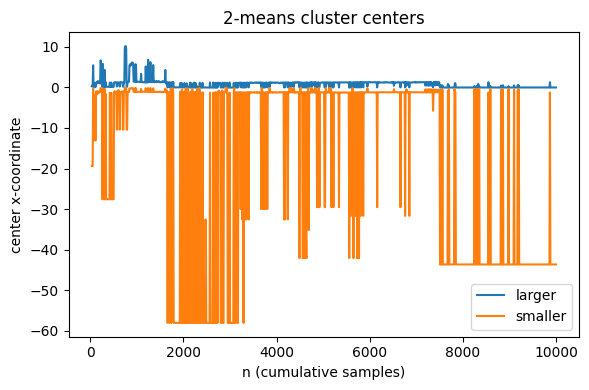

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import default_rng
from sklearn.cluster import KMeans

def pareto_2d_symmetric(alpha=2.0, n=10_000, xm=1.0, seed=123):
    rng = default_rng(seed)
    theta = rng.uniform(0.0, 2*np.pi, size=n)
    U = np.stack([np.cos(theta), np.sin(theta)], axis=1)
    Uu = rng.random(size=n)
    R = xm * (Uu ** (-1.0/alpha))
    return U * R[:, None]

# data
X = pareto_2d_symmetric(alpha=2.0, n=10_000, xm=1.0, seed=123)

# sweep n and record the x-coordinate of the two centers
ns = np.arange(30, X.shape[0] + 1, 10)
larger_x, smaller_x = [], []
hit_max = []   # 1 if n_iter reached max_iter

for n in ns:
    km = KMeans(
        n_clusters=2,
        n_init=1,
        max_iter=2000,
        tol=1e-12,
        random_state=0,
        algorithm="lloyd",
    ).fit(X[:n])

    C = km.cluster_centers_
    # order by x-coordinate so "smaller" and "larger" are comparable across n
    order = np.argsort(C[:, 0])
    smaller_x.append(C[order[0], 0])
    larger_x.append(C[order[1], 0])
    hit_max.append(int(km.n_iter_ >= km.max_iter))

larger_x = np.array(larger_x)
smaller_x = np.array(smaller_x)
hit_max = np.array(hit_max, dtype=bool)

# plot like your screenshot
plt.figure(figsize=(6, 4))
plt.plot(ns, larger_x, label="larger")
plt.plot(ns, smaller_x, label="smaller")
plt.title("2-means cluster centers")
plt.xlabel("n (cumulative samples)")
plt.ylabel("center x-coordinate")
plt.legend()

# optional: highlight points where k-means didn't meet tol
if hit_max.any():
    y_marks = np.interp(ns[hit_max], ns, (larger_x+smaller_x)/2)
    plt.scatter(ns[hit_max], y_marks, s=10)

plt.tight_layout()
plt.show()


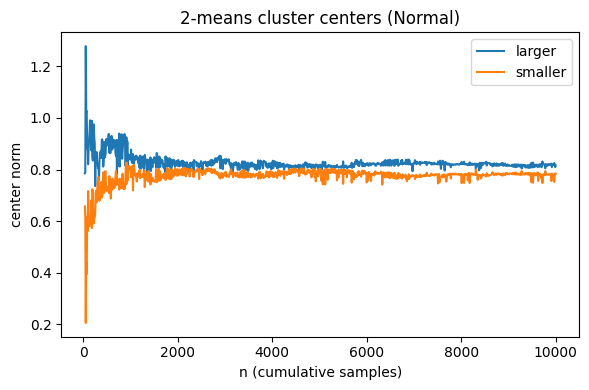

In [ ]:
# compare_kmeans_stream.py
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import default_rng
from sklearn.cluster import KMeans

rng = default_rng(123)

def pareto_2d_symmetric(alpha=2.0, n=10_000, xm=1.0, seed=123):
    r = default_rng(seed)
    theta = r.uniform(0.0, 2*np.pi, size=n)
    U = np.stack([np.cos(theta), np.sin(theta)], axis=1)
    Uu = r.random(size=n)
    R = xm * (Uu ** (-1.0/alpha))
    return U * R[:, None]

def normal_2d(mu=(0.0, 0.0), sigma=1.0, n=10_000, seed=123):
    r = default_rng(seed)
    return r.normal(loc=mu, scale=sigma, size=(n, 2))

def run_curve(X, step=10, tol=1e-12, max_iter=2000):
    ns = np.arange(30, X.shape[0] + 1, step)
    larger, smaller = [], []
    for n in ns:
        km = KMeans(
            n_clusters=2,
            n_init=1,
            max_iter=max_iter,
            tol=tol,
            random_state=0,
            algorithm="lloyd",
        ).fit(X[:n])
        norms = np.linalg.norm(km.cluster_centers_, axis=1)
        larger.append(norms.max())
        smaller.append(norms.min())
    return ns, np.array(larger), np.array(smaller)

if __name__ == "__main__":
    dist = "normal"   # change to "pareto" to see the spikes

    if dist == "normal":
        X = normal_2d(n=10_000, seed=1)          # finite variance → stabilization
    else:
        X = pareto_2d_symmetric(alpha=2.0, n=10_000, seed=1)  # infinite variance → spikes

    ns, big, small = run_curve(X, step=10, tol=1e-12, max_iter=2000)

    plt.figure(figsize=(6, 4))
    plt.plot(ns, big, label="larger")
    plt.plot(ns, small, label="smaller")
    ttl = "2-means cluster centers (Normal)" if dist=="normal" else "2-means cluster centers (Pareto α=2)"
    plt.title(ttl)
    plt.xlabel("n (cumulative samples)")
    plt.ylabel("center norm")
    plt.legend()
    plt.tight_layout()
    plt.show()


In [ ]:
import numpy as np

# Set mean and covariance matrix for the 2D normal distribution
mean = [0, 0]  # Mean of the distribution
cov = [[1, 0], [0, 1]]  # Covariance matrix (identity matrix for independent variables)

# Generate a 2D normal distribution
two_d_normal_dist = np.random.multivariate_normal(mean, cov, size=10000)

# Print the shape of the generated distribution
print(f"Shape of 2D normal distribution: {two_d_normal_dist.shape}")

Shape of 2D normal distribution: (10000, 2)


<Axes: >

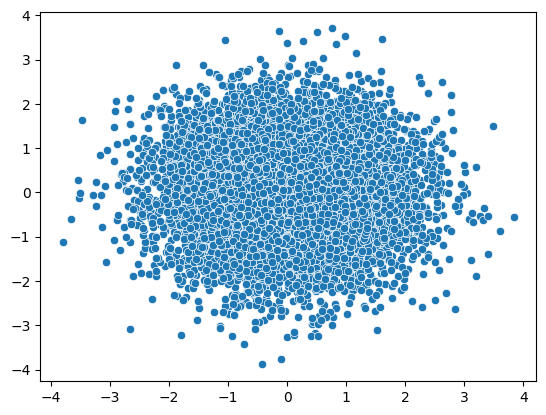

In [ ]:
import seaborn as sns
sns.scatterplot(x = two_d_normal_dist[:, 0], y= two_d_normal_dist[:, 1] )

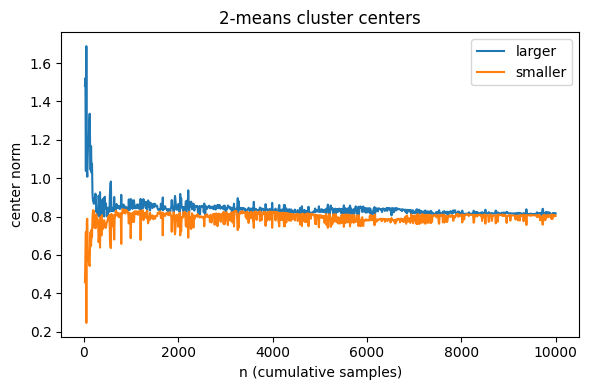

In [ ]:
ns = np.arange(20, two_d_normal_dist.shape[0] + 1, 10)   # evaluate every 10 points to keep it fast
larger, smaller = [], []

for n in ns:
    km = KMeans(
        n_clusters=2,
        n_init=1,          # highlight seed/initialization sensitivity
        max_iter=1000,     # high cap (won't always meet tol)
        tol=1e-10,         # strict tolerance → exposes non-convergence
        random_state=0,
        algorithm="lloyd",
    ).fit(two_d_normal_dist[:n])

    norms = np.linalg.norm(km.cluster_centers_, axis=1)
    larger.append(norms.max())
    smaller.append(norms.min())

# 3) Plot (single chart, no explicit colors/styles)
plt.figure(figsize=(6, 4))
plt.plot(ns, larger, label="larger")
plt.plot(ns, smaller, label="smaller")
plt.title("2-means cluster centers")
plt.xlabel("n (cumulative samples)")
plt.ylabel("center norm")
plt.legend()
plt.tight_layout()
plt.show()
